# <font color='red'>**Sequence to sequence implementation**</font>

**There will be some functions that start with the word "grader" ex: grader_check_encoder(), grader_check_attention(), grader_onestepdecoder() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

**Note 1:**  There are many blogs on the attention mechanisum which might be misleading you,
 so do read the references completly and after that only please check the internet.
 The best things is to read the research papers and try to implement it on your own. 

**Note 2:** To complete this assignment, the reference that are mentioned will be enough.

**Note 3:** If you are starting this assignment, you might have completed minimum of 20 assignment.
 If  you are still not able to implement this algorithm you might have rushed in the previous assignments 
with out learning much and didn't spend your time productively.

## Task -1: Simple Encoder and Decoder
Implement simple Encoder-Decoder model

1. Download the **Italian** to **English** translation dataset from <a href="http://www.manythings.org/anki/ita-eng.zip">here</a>

2. You will find **ita.txt** file in that ZIP, 
you can read that data using python and preprocess that data this way only: 
<img src='https://i.imgur.com/z0j79Jf.png'>    
    
3. You have to implement a simple Encoder and Decoder architecture  

4. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

5. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients. 

6.  a. Check the reference notebook <br>
    b. <a href="https://medium.com/analytics-vidhya/understand-sequence-to-sequence-models-in-a-more-intuitive-way-1d517d8795bb">Resource 2</a>
    



<font color='blue'>**Load the data**</font>

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.callbacks import*
import os
import datetime

In [ ]:
with open('/content/drive/MyDrive/Seq_Seq_attention/ita.txt', 'r', encoding="utf8") as f:
    eng=[]
    ita=[]
    for i in f.readlines():
        eng.append(i.split("\t")[0])
        ita.append(i.split("\t")[1])
data = pd.DataFrame(data=list(zip(eng, ita)), columns=['english','italian'])
print(data.shape)
data.head()

(352040, 2)


,english,italian
0,Hi.,Ciao!
1,Hi.,Ciao.
2,Run!,Corri!
3,Run!,Corra!
4,Run!,Correte!


<font color='blue'>**Preprocess data**</font>

In [ ]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text):
    # convert all the text into lower letters
    # use this function to remove the contractions: https://gist.github.com/anandborad/d410a49a493b56dace4f814ab5325bbd
    # remove all the spacial characters: except space ' '
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text

def preprocess_ita(text):
    # convert all the text into lower letters
    # remove the words betweent brakets ()
    # remove these characters: {'$', ')', '?', '"', '’', '.',  '°', '!', ';', '/', "'", '€', '%', ':', ',', '('}
    # replace these spl characters with space: '\u200b', '\xa0', '-', '/'
    # we have found these characters after observing the data points, feel free to explore more and see if you can do find more
    # you are free to do more proprocessing
    # note that the model will learn better with better preprocessed data 
    
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    return text


data['english'] = data['english'].apply(preprocess)
data['italian'] = data['italian'].apply(preprocess_ita)
data.head()

,english,italian
0,hi,ciao
1,hi,ciao
2,run,corri
3,run,corra
4,run,correte


In [ ]:
ita_lengths = data['italian'].str.split().apply(len)
eng_lengths = data['english'].str.split().apply(len)

In [ ]:
for i in range(0,101,10):
    print(i,np.percentile(ita_lengths, i))
for i in range(90,101):
    print(i,np.percentile(ita_lengths, i))
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(ita_lengths, i))

0 1.0
10 3.0
20 4.0
30 4.0
40 5.0
50 5.0
60 6.0
70 6.0
80 7.0
90 8.0
100 92.0
90 8.0
91 8.0
92 8.0
93 9.0
94 9.0
95 9.0
96 10.0
97 10.0
98 11.0
99 12.0
100 92.0
99.1 12.0
99.2 12.0
99.3 13.0
99.4 13.0
99.5 13.0
99.6 14.0
99.7 15.0
99.8 16.0
99.9 22.0
100 92.0


In [ ]:
for i in range(0,101,10):
    print(i,np.percentile(eng_lengths, i))
for i in range(90,101):
    print(i,np.percentile(eng_lengths, i))
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(eng_lengths, i))

0 1.0
10 4.0
20 4.0
30 5.0
40 5.0
50 6.0
60 6.0
70 7.0
80 7.0
90 8.0
100 101.0
90 8.0
91 9.0
92 9.0
93 9.0
94 9.0
95 9.0
96 10.0
97 10.0
98 11.0
99 12.0
100 101.0
99.1 12.0
99.2 13.0
99.3 13.0
99.4 13.0
99.5 14.0
99.6 14.0
99.7 15.0
99.8 16.0
99.9 25.0
100 101.0


In [ ]:
data['italian_len'] = data['italian'].str.split().apply(len)
data = data[data['italian_len'] < 20]

data['english_len'] = data['english'].str.split().apply(len)
data = data[data['english_len'] < 20]

data['english_inp'] = '<start> ' + data['english'].astype(str)
data['english_out'] = data['english'].astype(str) + ' <end>'

data = data.drop(['english','italian_len','english_len'], axis=1)
# only for the first sentance add a toke <end> so that we will have <end> in tokenizer
data.head()

,italian,english_inp,english_out
0,ciao,<start> hi,hi <end>
1,ciao,<start> hi,hi <end>
2,corri,<start> run,run <end>
3,corra,<start> run,run <end>
4,correte,<start> run,run <end>


In [ ]:
data.sample(10)

,italian,english_inp,english_out
238592,era preoccupata vero,<start> you were worried were not you,you were worried were not you <end>
48044,so che lho fatto,<start> i know i did that,i know i did that <end>
123387,per favore correggi il mio conto,<start> please correct my bill,please correct my bill <end>
297582,tom spiegò la situazione a mary,<start> tom explained the situation to mary,tom explained the situation to mary <end>
332792,mary è una ragazza con cui è piacevole parlare,<start> mary is a girl who is pleasant to talk...,mary is a girl who is pleasant to talk with <end>
112251,provate a pensarci,<start> try to think about it,try to think about it <end>
184716,io sto ascoltando questa band,<start> i am listening to this band,i am listening to this band <end>
204319,tom accettò linevitabile,<start> tom accepted the inevitable,tom accepted the inevitable <end>
12245,mi ha mentito,<start> he lied to me,he lied to me <end>
316662,perché non andate a sedervi al tavolo,<start> why do not you go sit down at the table,why do not you go sit down at the table <end>


In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size = 0.1, random_state = 0)


In [ ]:
print(train.shape, test.shape)
# for one sentence we will be adding <end> token so that the tokanizer learns the word <end>
# with this we can use only one tokenizer for both encoder output and decoder output
train.iloc[0]['english_inp']= str(train.iloc[0]['english_inp'])+' <end>'
train.iloc[0]['english_out']= str(train.iloc[0]['english_out'])+' <end>'

(316399, 3) (35156, 3)


In [ ]:
train.head()

,italian,english_inp,english_out
9566,liberi tom,<start> set tom free <end>,set tom free <end> <end>
333330,tom non sa farsi capire in francese,<start> tom can not make himself understood in...,tom can not make himself understood in french ...
256099,penso che mi dovrebbe ascoltare,<start> i think you should listen to me,i think you should listen to me <end>
340320,penso che faremmo meglio ad aspettare altri tr...,<start> i think we would better wait another t...,i think we would better wait another thirty mi...
127911,non abbiamo detto niente,<start> we did not say anything,we did not say anything <end>


In [ ]:
test.head()

,italian,english_inp,english_out
148349,non pensi che non abbia provato,<start> do not think i did not try,do not think i did not try <end>
97165,abbiamo cambiato idea,<start> we changed our minds,we changed our minds <end>
333265,quelle persone laggiù stanno parlando in francese,<start> those people over there are speaking f...,those people over there are speaking french <end>
215475,io voglio costruire una casa qui,<start> i want to build a house here,i want to build a house here <end>
62024,starò con tom,<start> i will stay with tom,i will stay with tom <end>


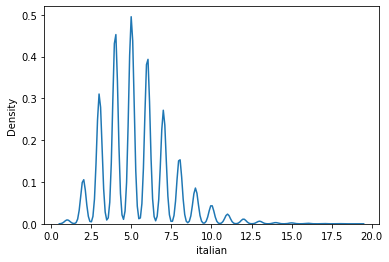

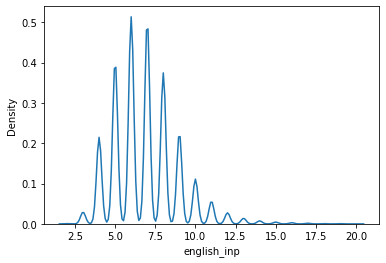

In [ ]:
ita_lengths = train['italian'].str.split().apply(len)
eng_lengths = train['english_inp'].str.split().apply(len)
import seaborn as sns
sns.kdeplot(ita_lengths)
plt.show()
sns.kdeplot(eng_lengths)
plt.show()

In [ ]:
tknizer_ita = Tokenizer()
tknizer_ita.fit_on_texts(train['italian'].values)
tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_eng.fit_on_texts(train['english_inp'].values)

In [ ]:
vocab_size_eng=len(tknizer_eng.word_index.keys())
print(vocab_size_eng)
vocab_size_ita=len(tknizer_ita.word_index.keys())
print(vocab_size_ita)

13363
27508


In [ ]:
tknizer_eng.word_index['<start>'], tknizer_eng.word_index['<end>']

(1, 10710)

## <font color='blue'>**Implement custom encoder decoder**</font>

<font color='blue'>**Encoder**</font>

In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        self.inp_vocab_size = inp_vocab_size
        self.embedding_size = embedding_size
        self.lstm_size = lstm_size
        self.input_length = input_length
        #Initialize Embedding layer
        self.encoder_embedding = Embedding(input_dim = inp_vocab_size,
                                           output_dim = embedding_size,
                                           input_length= input_length)
        #Intialize Encoder LSTM layer
        self.encoder_Lstm = LSTM(lstm_size, return_sequences = True, return_state = True)

    def call(self,input_sequence,states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- encoder_output, last time step's hidden and cell state
        '''
        input_embedding = self.encoder_embedding(input_sequence)
        encoder_output_state, encoder_h, encoder_c = self.encoder_Lstm(input_embedding, initial_state = states)
        return encoder_output_state, encoder_h, encoder_c

    
    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      '''
      return [tf.zeros((batch_size, self.lstm_size)), tf.zeros((batch_size, self.lstm_size))]


<font color='orange'>**Grader function - 1**</font>

In [ ]:
def grader_check_encoder():
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units,
        input_length: Length of the input sentence,
        batch_size
    '''
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    #Intialzing encoder 
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    #Intializing encoder initial states
    initial_state=encoder.initialize_states(batch_size)
    
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

True


In [ ]:
class Decoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        self.out_vocab_size = out_vocab_size
        self.embedding_size = embedding_size
        self.lstm_size = lstm_size
        self.input_length = input_length
        #Initialize Embedding layer
        self.decoder_embedding = Embedding(input_dim = out_vocab_size, 
                                           output_dim = embedding_size, 
                                           input_length = input_length)
        #Intialize Decoder LSTM layer
        self.decoder_LSTM = LSTM(lstm_size, return_sequences = True, return_state = True)

    def call(self,input_sequence,initial_states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to decoder_lstm
        
          returns -- decoder_output,decoder_final_state_h,decoder_final_state_c
        '''
        target_embedding = self.decoder_embedding(input_sequence)
        decoder_output_state,  decoder_h,  decoder_c = self.decoder_LSTM(target_embedding, 
                                                                         initial_state = initial_states)
        return decoder_output_state, decoder_h, decoder_c
      


<font color='orange'>**Grader function - 2**</font>

In [ ]:
def grader_decoder():
    '''
        out_vocab_size: Unique words of the target language,
        embedding_size: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        input_length: Length of the input sentence,
        batch_size
        
    
    '''
    out_vocab_size=13 
    embedding_dim=12 
    input_length=10
    dec_units=16 
    batch_size=32
    
    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    states=[state_h,state_c]
    decoder=Decoder(out_vocab_size, embedding_dim, dec_units,input_length )
    output,_,_=decoder(target_sentences, states)
    assert(output.shape==(batch_size,input_length,dec_units))
    return True
print(grader_decoder())


True


In [ ]:
class Encoder_decoder(tf.keras.Model):
    
    def __init__(self,*params):
        super().__init__()
        #Create encoder object
        self.encoder = Encoder(inp_vocab_size = params[0], 
                               embedding_size = params[2], 
                               lstm_size = params[3], input_length = params[4])
        #Create decoder object
        self.decoder = Decoder(out_vocab_size = params[1], 
                              embedding_size = params[2], 
                              lstm_size = params[3], input_length = params[5])
        #Intialize Dense layer(out_vocab_size) with activation='softmax'
        self.dense = Dense(params[1], activation='softmax')
    
    def call(self,params, training = True):
        '''
        A. Pass the input sequence to Encoder layer -- Return encoder_output,encoder_final_state_h,encoder_final_state_c
        B. Pass the target sequence to Decoder layer with intial states as encoder_final_state_h,encoder_final_state_C
        C. Pass the decoder_outputs into Dense layer 
        
        Return decoder_outputs
        '''
        enc_inp, dec_inp = params[0], params[1]
        initial_state = self.encoder.initialize_states(batch_size)
        output_state, enc_h, enc_c = self.encoder(enc_inp, initial_state)
        output, _, _ = self.decoder(dec_inp ,[enc_h, enc_c])
        return self.dense(output)
        
        

In [ ]:

class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len     = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))

    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
#         print(batch[0].shape, batch[1].shape, batch[2].shape)
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[tf.convert_to_tensor(batch[0]), tf.convert_to_tensor(batch[1])], tf.convert_to_tensor(batch[2])])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [ ]:
batch_size=128
lstm_size=64
max_len = 20
embedding_dim = 100
dense_units = 64

train_dataset = Dataset(train, tknizer_ita, tknizer_eng, max_len)
test_dataset  = Dataset(test, tknizer_ita, tknizer_eng, max_len)

train_dataloader = Dataloder(train_dataset, batch_size=batch_size)
test_dataloader = Dataloder(test_dataset, batch_size=batch_size)

In [ ]:
model = Encoder_decoder(vocab_size_ita+1, vocab_size_eng+1, 
                        embedding_dim, lstm_size, max_len, dense_units)
model.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy',metrics='acc')
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [ModelCheckpoint('encoder_decoder', save_best_only= True, verbose = 1),
             TensorBoard(log_dir = log_dir, histogram_freq=1, write_graph=True),
             EarlyStopping(patience = 5, verbose = 1, monitor='val_loss',mode = 'min'),
             ReduceLROnPlateau(patience = 3,factor=0.6, monitor='val_loss',mode = 'min',verbose = 1)]

model.fit(x = train_dataloader, 
          steps_per_epoch = train_dataloader.__len__(),
          validation_data = test_dataloader,
          validation_steps = test_dataloader.__len__(),
          epochs = 30,
          verbose = 1,
          callbacks = callbacks)
model.save_weights('/kaggle/working/model.h5')

Epoch 1/30
2471/2471 [==============================] - 196s 78ms/step - loss: 2.4140 - acc: 0.7061 - val_loss: 1.1414 - val_acc: 0.8046

Epoch 00001: val_loss improved from inf to 1.14136, saving model to encoder_decoder
Epoch 2/30
2471/2471 [==============================] - 189s 77ms/step - loss: 1.0539 - acc: 0.8175 - val_loss: 0.8513 - val_acc: 0.8462

Epoch 00002: val_loss improved from 1.14136 to 0.85134, saving model to encoder_decoder
Epoch 3/30
2471/2471 [==============================] - 190s 77ms/step - loss: 0.7915 - acc: 0.8545 - val_loss: 0.6814 - val_acc: 0.8710

Epoch 00003: val_loss improved from 0.85134 to 0.68142, saving model to encoder_decoder
Epoch 4/30
2471/2471 [==============================] - 189s 77ms/step - loss: 0.6227 - acc: 0.8791 - val_loss: 0.5646 - val_acc: 0.8896

Epoch 00004: val_loss improved from 0.68142 to 0.56458, saving model to encoder_decoder
Epoch 5/30
2471/2471 [==============================] - 190s 77ms/step - loss: 0.5045 - acc: 0.8977 

In [ ]:
model.layers

In [ ]:
def predict(input_sentence):
    '''
      A. Given input sentence, convert the sentence into integers using tokenizer used earlier
      B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
      C. Initialize index of <start> as input to decoder. and encoder final states as input_states to decoder
      D. till we reach max_length of decoder or till the model predicted word <end>:
         predicted_out,state_h,state_c=model.layers[1](dec_input,states)
         pass the predicted_out to the dense layer
         update the states=[state_h,state_c]
         And get the index of the word with maximum probability of the dense layer output, 
         using the tokenizer(word index) get the word and then store it in a string.
         Update the input_to_decoder with current predictions
      F. Return the predicted sentence
    '''
    sentencce = '<start> '+input_sentence+' <end>'
    sentencce = tknizer_ita.texts_to_sequences([sentencce])
    sentencce = pad_sequences(sentencce, maxlen=max_len, 
                              padding='post', dtype = np.int32)
    
    input_embedding = model.layers[0].encoder_embedding(sentencce)
    initial_state =  model.layers[0].initialize_states(1)
    ecoder_output, encoder_h, encoder_c = model.layers[0].encoder_Lstm(input_embedding,initial_state)
    predict = np.expand_dims([tknizer_eng.word_index['<start>']], 0)
    decoder_h = encoder_h
    decoder_c = encoder_c
    prediction = []
    for words in range(max_len):
        predict, decoder_h,decoder_c = model.layers[1](predict, [decoder_h, decoder_c])
        predict = model.layers[2](predict)
        predict = np.reshape(np.argmax(predict), (1, 1))
        prediction.append(predict)
    return prediction

def get_sentence(prediction):
    output = []
    for i in result:
        word = tknizer_eng.index_word[i[0][0]]
        if word == '<end>':
            break
        output.append(word)
    return ' '.join(output)

In [ ]:
sentence = "non pensi che non abbia provato	"
print('input : ', sentence)
result = predict(sentence)
output = get_sentence(result)
print('predicted output : ',output)


input :  non pensi che non abbia provato	
predicted output :  do not you think i have not forgotten


In [ ]:
sentence = train['italian'].values[5]
print('input : ', sentence)
result = predict(sentence)
output = get_sentence(result)
print('predicted output : ',output)
print('actual output :', train['english_out'].values[5])

input :  tom è preparato per qualsiasi cosa possa capitare
predicted output :  tom is prepared for anything that can happen
actual output : tom is prepared for whatever may happen <end>


In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from numpy.random import permutation

score =0
for i in permutation(1000):
    sentence = test['italian'].values[i]
    reference = test['english_out'].values[i]
    result = predict(sentence)
    output = get_sentence(result)
    score+= sentence_bleu([reference.split()],output.split())
print('Bleu Score : {}'.format(score/1000))

Bleu Score : 0.6640184782391946


## Task -2: Including Attention mechanisum

1. Use the preprocessed data from Task-1

2. You have to implement an Encoder and Decoder architecture with  
attention as discussed in the reference notebook.

    * Encoder   - with 1 layer LSTM <br>
    * Decoder   - with 1 layer LSTM<br>
    * attention -  (Please refer the <a href= 'https://drive.google.com/file/d/1z_bnc-3aubKawbR6q8wyI6Mh5ho2R1aZ/view?usp=sharing'>**reference notebook**</a> to know more about the attention mechanism.)
3. In Global attention, we have 3 types of scoring functions(as discussed in the reference notebook).
 As a part of this assignment **you need to create 3 models for each scoring function**
<img src='https://i.imgur.com/iD2jZo3.png'>

    * In model 1 you need to implemnt "dot" score function
    * In model 2 you need to implemnt "general" score function
    * In model 3 you need to implemnt "concat" score function.<br>
    
 **Please do add the markdown titles for each model so that we can have a better look at the code and verify.**
4. It is mandatory to train the model with simple model.fit() only, Donot train the model with custom GradientTape()

5. Using attention weights, you can plot the attention plots, 
please plot those for 2-3 examples. You can check about those in <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate">this</a>

6. The attention layer has to be written by yourself only. 
The main objective of this assignment is to read and implement a paper on yourself so please do it yourself.  

7. Please implement the class **onestepdecoder** as mentioned in the assignment instructions.

8. You can use any tf.Keras highlevel API's to build and train the models. 
 Check the reference notebook for better understanding.

9. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

10. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients. 

11. Resources:
    a. Check the reference notebook
    b. <a href="https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/">Resource 1</a>
    c. <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">Resource 2</a>
    d. <a href="https://stackoverflow.com/questions/44238154/what-is-the-difference-between-luong-attention-and-bahdanau-attention#:~:text=Luong%20attention%20used%20top%20hidden,hidden%20state%20at%20time%20t.">Resource 3</a>
    

### <font color='blue'>**Implement custom encoder decoder and attention layers**</font>

<font color='blue'>**Encoder**</font>

In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        self.inp_vocab_size = inp_vocab_size
        self.embedding_size = embedding_size
        self.lstm_size = lstm_size
        self.input_length =input_length
        #Initialize Embedding layer
        self.encoder_embedding = Embedding(input_dim = inp_vocab_size,
                                           output_dim = embedding_size,
                                           input_length= input_length)
        #Intialize Encoder LSTM layer
        self.encoder_Lstm = LSTM(lstm_size, return_sequences = True, return_state = True)

    def call(self,input_sequence,states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- All encoder_outputs, last time steps hidden and cell state
        '''
        input_embedding = self.encoder_embedding(input_sequence)
        encoder_output_state, encoder_h, encoder_c = self.encoder_Lstm(input_embedding, initial_state = states)
        return encoder_output_state, encoder_h, encoder_c
    
    def initialize_states(self,batch_size):
        '''
          Given a batch size it will return intial hidden state and intial cell state.
          If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
        '''
        return [tf.zeros((batch_size, self.lstm_size)), tf.zeros((batch_size, self.lstm_size))]


<font color='cyan'>**Grader function - 1**</font>

In [ ]:
def grader_check_encoder():
    
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units in encoder,
        input_length: Length of the input sentence,
        batch_size
    '''
    
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    initial_state=encoder.initialize_states(batch_size)
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

True


<font color='blue'>**Attention**</font>

In [ ]:
from tensorflow.keras.layers import *
class Attention(tf.keras.layers.Layer):
    '''
        Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
        '''
    def __init__(self,scoring_function, att_units):
        super(Attention, self).__init__()
        self.scoring_function = scoring_function
        # Please go through the reference notebook and research paper to complete the scoring functions

        if self.scoring_function=='dot':
            self.dot = Dot(axes = (1, 2))
          # Intialize variables needed for Dot score function here
            pass
        if scoring_function == 'general':
            self.D_0 = Dense(att_units)
            self.dot = Dot(axes = (1, 2))
            # Intialize variables needed for General score function here
            pass
        elif scoring_function == 'concat':
            self.D_1 = Dense(att_units)
            self.D_2 = Dense(att_units)
            self.h = Dense(1)
            # Intialize variables needed for Concat score function here
            pass
  
    def call(self,decoder_hidden_state,encoder_output):
        '''
          Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
          * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
            Multiply the score function with your encoder_outputs to get the context vector.
            Function returns context vector and attention weights(softmax - scores)
        '''
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, 1)
        # Implement Dot score function here
        if self.scoring_function == 'dot':
            score = tf.transpose(self.dot([tf.transpose(decoder_hidden_state, (0, 2, 1)),
                                       encoder_output]), (0, 2,1))
            pass
        elif self.scoring_function == 'general':
            out = self.D_0(encoder_output)
            score = tf.transpose(self.dot([tf.transpose(decoder_hidden_state, (0, 2, 1)), 
                                           out]), (0, 2,1))
        # Implement General score function here
            pass
        elif self.scoring_function == 'concat':
            stick = self.D_1(decoder_hidden_state) + self.D_2(encoder_output)
            tan_h = tf.nn.tanh(stick)
            score = self.h(tan_h)
            # Implement General score function here
            pass
        attention_weights = tf.nn.softmax(score, axis =1)
        context_vector = attention_weights * encoder_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights
    

<font color='cyan'>**Grader function - 2**</font>

In [ ]:
def grader_check_attention(scoring_fun):
    
    ''' 
        att_units: Used in matrix multiplications for scoring functions,
        input_length: Length of the input sentence,
        batch_size
    '''
    
    input_length=10
    batch_size=16
    att_units=32
    
    state_h=tf.random.uniform(shape=[batch_size,att_units])
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,att_units])
    attention=Attention(scoring_fun,att_units)
    context_vector,attention_weights=attention(state_h,encoder_output)
    assert(context_vector.shape==(batch_size,att_units) and attention_weights.shape==(batch_size,input_length,1))
    return True
print(grader_check_attention('dot'))
print(grader_check_attention('general'))
print(grader_check_attention('concat'))

True
True
True


<font color='blue'>**OneStepDecoder**</font>

In [ ]:
class OneStepDecoder(tf.keras.Model):
  def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
    super().__init__()
    # Initialize decoder embedding layer, LSTM and any other objects needed
    self.decoder_embeddings = Embedding(input_dim = tar_vocab_size, output_dim = embedding_dim)
    self.decoder_LSTM = LSTM(dec_units, return_sequences = True, return_state = True)
    self.attention = Attention(scoring_function = score_fun, att_units = att_units)
    self.feed_forward = Dense(tar_vocab_size)

  def call(self,input_to_decoder, encoder_output, state_h,state_c):
    '''
        One step decoder mechanisim step by step:
      A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step -B
    '''
    decoder_embd = self.decoder_embeddings(input_to_decoder)
    context_vector, attention_weights = self.attention(state_h, encoder_output)
    concat_input = tf.concat([tf.expand_dims(context_vector, 1), decoder_embd], axis = -1)
    decoder_output_states, decoder_h, decoder_c = self.decoder_LSTM(concat_input, [state_h, state_c])
    output = tf.reshape(decoder_output_states, (-1, decoder_output_states.shape[2]))
    output = self.feed_forward(output)
    return output, decoder_h, decoder_c, attention_weights, context_vector
    

<font color='cyan'>**Grader function - 3**</font>

In [ ]:
def grader_onestepdecoder(score_fun):
    
    '''
        tar_vocab_size: Unique words of the target language,
        embedding_dim: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        att_units: Used in matrix multiplications for scoring functions in attention class,
        input_length: Length of the target sentence,
        batch_size
        
    
    '''
    
    tar_vocab_size=13 
    embedding_dim=12 
    input_length=10
    dec_units=16 
    att_units=16
    batch_size=32
    onestepdecoder=OneStepDecoder(tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    input_to_decoder=tf.random.uniform(shape=(batch_size,1),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    output,state_h,state_c,attention_weights,context_vector=onestepdecoder(input_to_decoder,encoder_output,state_h,state_c)
    assert(output.shape==(batch_size,tar_vocab_size))
    assert(state_h.shape==(batch_size,dec_units))
    assert(state_c.shape==(batch_size,dec_units))
    assert(attention_weights.shape==(batch_size,input_length,1))
    assert(context_vector.shape==(batch_size,dec_units))
    return True
    
print(grader_onestepdecoder('dot'))
print(grader_onestepdecoder('general'))
print(grader_onestepdecoder('concat'))
    

True
True
True


<font color='blue'>**Decoder**</font>

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
        super().__init__()
      #Intialize necessary variables and create an object from the class onestepdecoder
        self.out_vocab_size = out_vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.dec_units = dec_units
        self.score_fun = score_fun
        self.att_units = att_units
        self.one_step_decoder = OneStepDecoder(out_vocab_size, embedding_dim, input_length, 
                                               dec_units ,score_fun ,att_units)
        
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state ):

        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        all_outputs = tf.TensorArray(dtype = tf.float32, 
                                     size= input_to_decoder.shape[1], name='output_arrays')
        #Create a tensor array as shown in the reference notebook
        for timestep in range(input_to_decoder.shape[1]):
            output, decoder_hidden_state, decoder_cell_state, _, _ = self.one_step_decoder(
                input_to_decoder[:, timestep:timestep+1], 
                encoder_output, decoder_hidden_state,decoder_cell_state)
        #Iterate till the length of the decoder input
            # Call onestepdecoder for each token in decoder_input
            # Store the output in tensorarray
            all_outputs = all_outputs.write(timestep, output)
        # Return the tensor array
        all_outputs = tf.transpose(all_outputs.stack(), (1, 0, 2))
        return all_outputs
        
    

<font color='cyan'>**Grader function - 4**</font>

In [ ]:
def grader_decoder(score_fun):
    
    '''
        out_vocab_size: Unique words of the target language,
        embedding_dim: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        att_units: Used in matrix multiplications for scoring functions in attention class,
        input_length: Length of the target sentence,
        batch_size
        
    
    '''
    
    out_vocab_size=13 
    embedding_dim=12 
    input_length=11
    dec_units=16 
    att_units=16
    batch_size=32
    
    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    
    decoder=Decoder(out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    output=decoder(target_sentences,encoder_output, state_h, state_c)
    assert(output.shape==(batch_size,input_length,out_vocab_size))
    return True
print(grader_decoder('dot'))
print(grader_decoder('general'))
print(grader_decoder('concat'))

True
True
True


<font color='blue'>**Encoder Decoder model**</font>

In [ ]:
class encoder_decoder(tf.keras.Model):
  def __init__(self, inp_vocab_size, out_vocab_size, embedding_dim, 
               enc_units, dec_units, max_len, score_fun, att_units, batch_size):
    super().__init__()
    #Intialize objects from encoder decoder
    self.encoder = Encoder(inp_vocab_size, embedding_dim, enc_units, max_len)
    self.one_step_decoder = OneStepDecoder(out_vocab_size, embedding_dim,
                                           max_len, dec_units ,score_fun ,att_units)
    self.batch_size = batch_size

  @tf.function
  def call(self,data):
    #Intialize encoder states, Pass the encoder_sequence to the embedding layer
    encoder_inp, decoder_inp = data[0], data[1]
    initial_state = self.encoder.initialize_states(self.batch_size)
    encoder_output, encoder_h, encoder_c = self.encoder(encoder_inp, initial_state)
    all_outputs = tf.TensorArray(dtype = tf.float32, size= max_len)
    # Decoder initial states are encoder final states, Initialize it accordingly
    decoder_h = encoder_h
    decoder_c = encoder_c
    # Pass the decoder sequence,encoder_output,decoder states to Decoder
    for timestep in range(max_len):
        decoder_output, decoder_h, decoder_c, _, _ = self.one_step_decoder(decoder_inp[:, timestep:timestep+1], 
                                                               encoder_output, 
                                                               decoder_h,
                                                               decoder_c)
        all_outputs = all_outputs.write(timestep, decoder_output)
    all_outputs = tf.transpose(all_outputs.stack(), (1, 0, 2))
    # return the decoder output
    return all_outputs



<font color='blue'>**Custom loss function**</font>

In [ ]:
#https://www.tensorflow.org/tutorials/text/image_captioning#model
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    """ Custom loss function that will not consider the loss for padded zeros.
    why are we using this, can't we use simple sparse categorical crossentropy?
    Yes, you can use simple sparse categorical crossentropy as loss like we did in task-1. But in this loss function we are ignoring the loss
    for the padded zeros. i.e when the input is zero then we donot need to worry what the output is. This padded zeros are added from our end
    during preprocessing to make equal length for all the sentences.

    """
    
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

# <font color='blue'>**1 . Model with Dot Scoring function**</font>

In [ ]:
from tensorflow.keras.callbacks import*
import os
batch_size=128
enc_unit=512
dec_unit=512
max_len = 20
embedding_dim = 256
att_units = 256

train_dataset = Dataset(train, tknizer_ita, tknizer_eng, max_len)
test_dataset  = Dataset(test, tknizer_ita, tknizer_eng, max_len)

train_dataloader = Dataloder(train_dataset, batch_size=batch_size)
test_dataloader = Dataloder(test_dataset, batch_size=batch_size)


In [ ]:
Attention_dot_model = encoder_decoder(vocab_size_ita+1, vocab_size_eng+1, embedding_dim, enc_unit,
                        dec_unit, max_len ,'dot', att_units, batch_size)
Attention_dot_model.compile(optimizer = 'Adam', loss = loss_function)
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [ModelCheckpoint('/content/drive/MyDrive/Seq_Seq_attention/Save/Attention_dot', save_best_only= True, verbose = 1),
             TensorBoard(log_dir = log_dir, histogram_freq=1, write_graph=True),
             EarlyStopping(patience = 3, verbose = 1, monitor = 'val_loss', mode='min'),
             ReduceLROnPlateau(patience = 1, verbose = 1, monior='val_loss', mode = 'min', factor = 0.6)]

In [ ]:
Attention_dot_model.fit(x = train_dataloader, 
          steps_per_epoch = train_dataloader.__len__(),
          validation_data = test_dataloader,
          validation_steps = test_dataloader.__len__(),
          epochs = 10,
          verbose = 1,
          callbacks = callbacks)


Epoch 1/10
2471/2471 [==============================] - 676s 266ms/step - loss: 1.1423 - val_loss: 0.6849

Epoch 00001: val_loss improved from inf to 0.68489, saving model to /content/drive/MyDrive/Seq_Seq_attention/Save/Attention_dot


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/Attention_dot/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/Attention_dot/assets


Epoch 2/10
2471/2471 [==============================] - 651s 263ms/step - loss: 0.4629 - val_loss: 0.3264

Epoch 00002: val_loss improved from 0.68489 to 0.32640, saving model to /content/drive/MyDrive/Seq_Seq_attention/Save/Attention_dot


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/Attention_dot/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/Attention_dot/assets


Epoch 3/10
2471/2471 [==============================] - 651s 264ms/step - loss: 0.2326 - val_loss: 0.2236

Epoch 00003: val_loss improved from 0.32640 to 0.22356, saving model to /content/drive/MyDrive/Seq_Seq_attention/Save/Attention_dot


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/Attention_dot/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/Attention_dot/assets


Epoch 4/10
2471/2471 [==============================] - 651s 263ms/step - loss: 0.1472 - val_loss: 0.1859

Epoch 00004: val_loss improved from 0.22356 to 0.18594, saving model to /content/drive/MyDrive/Seq_Seq_attention/Save/Attention_dot


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/Attention_dot/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/Attention_dot/assets


Epoch 5/10
2471/2471 [==============================] - 651s 263ms/step - loss: 0.1053 - val_loss: 0.1677

Epoch 00005: val_loss improved from 0.18594 to 0.16772, saving model to /content/drive/MyDrive/Seq_Seq_attention/Save/Attention_dot


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/Attention_dot/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/Attention_dot/assets


Epoch 6/10
2471/2471 [==============================] - 651s 263ms/step - loss: 0.0804 - val_loss: 0.1570

Epoch 00006: val_loss improved from 0.16772 to 0.15700, saving model to /content/drive/MyDrive/Seq_Seq_attention/Save/Attention_dot


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/Attention_dot/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/Attention_dot/assets


Epoch 7/10
2471/2471 [==============================] - 651s 264ms/step - loss: 0.0645 - val_loss: 0.1518

Epoch 00007: val_loss improved from 0.15700 to 0.15183, saving model to /content/drive/MyDrive/Seq_Seq_attention/Save/Attention_dot


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/Attention_dot/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/Attention_dot/assets


Epoch 8/10
2471/2471 [==============================] - 652s 264ms/step - loss: 0.0535 - val_loss: 0.1502

Epoch 00008: val_loss improved from 0.15183 to 0.15019, saving model to /content/drive/MyDrive/Seq_Seq_attention/Save/Attention_dot


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/Attention_dot/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/Attention_dot/assets


Epoch 9/10
2471/2471 [==============================] - 652s 264ms/step - loss: 0.0460 - val_loss: 0.1488

Epoch 00009: val_loss improved from 0.15019 to 0.14883, saving model to /content/drive/MyDrive/Seq_Seq_attention/Save/Attention_dot


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/Attention_dot/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/Attention_dot/assets


Epoch 10/10
2471/2471 [==============================] - 651s 263ms/step - loss: 0.0402 - val_loss: 0.1497

Epoch 00010: val_loss did not improve from 0.14883

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.


In [ ]:
Attention_dot_model.layers

# <font color='blue'>**1.1 Inference Model-1**</font>

<font color='blue'>**Plot attention weights**</font>

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
  #Refer: https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate


<font color='blue'>**Predict the sentence translation**</font>

In [ ]:
def predict_model_1(input_sentence):
    '''
      A. Given input sentence, convert the sentence into integers using tokenizer used earlier
      B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
      C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
      D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
      E. Call plot_attention(#params)
      F. Return the predicted sentence
    '''
    sentencce = '<start> '+input_sentence+' <end>'
    sentencce = tknizer_ita.texts_to_sequences([sentencce])
    sentencce = pad_sequences(sentencce, maxlen=max_len, 
                              padding='post', dtype = np.int32)
    
    input_embedding = Attention_dot_model.layers[0].encoder_embedding(sentencce)
    initial_state =  Attention_dot_model.layers[0].initialize_states(1)
    ecoder_output, encoder_h, encoder_c = Attention_dot_model.layers[0].encoder_Lstm(input_embedding,initial_state)
    predict = np.expand_dims([tknizer_eng.word_index['<start>']], 0)
    decoder_h = encoder_h
    decoder_c = encoder_c
    prediction = []
    total_attention = []
    for words in range(max_len):
        predict, decoder_h,decoder_c,attention,_ = Attention_dot_model.layers[1](predict,ecoder_output,
                                                                                             decoder_h,decoder_c,training = False)
        predict = np.reshape(np.argmax(predict), (1, 1))                                                                                      
        prediction.append(predict)
        total_attention.append(attention)
    return prediction, total_attention

def get_sentence(prediction):
    output = []
    for i in prediction:
        word = tknizer_eng.index_word[i[0][0]]
        if word == '<end>':
            break
        output.append(word)
    return ' '.join(output)

In [ ]:
sentence = "non mi trattate come una bambina"
print('input : ', sentence)
result,weights = predict(sentence)
output = get_sentence(result)
print('predicted output : ',output)


input :  non mi trattate come una bambina
predicted output :  do not treat me like a child


input :  non mi trattate come una bambina


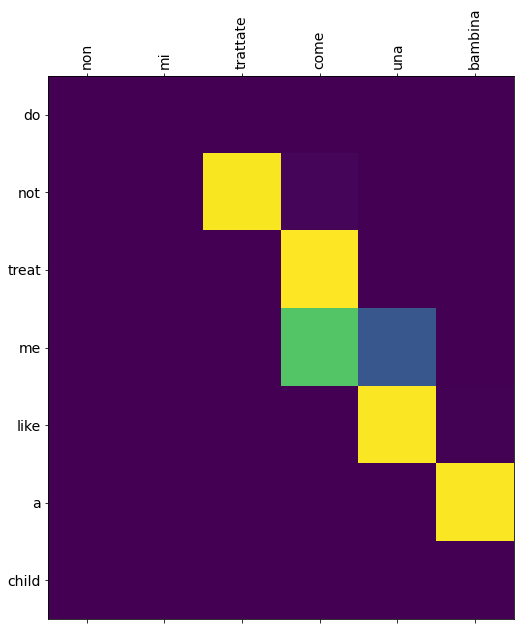

predicted output :  do not treat me like a child
actual output : do not treat me like a child <end>


In [ ]:
import warnings
warnings.filterwarnings("ignore")

sentence = test['italian'].values[5]
print('input : ', sentence)
result, attention_plot = predict(sentence)
output = get_sentence(result)
attention_plot = np.squeeze(np.squeeze(np.array(attention_plot), 1), -1)
attention_plot = attention_plot[:len(output.split(' ')), :len(sentence.split(' '))]
plot_attention(attention_plot, sentence.split(' '), output.split(' '))
print('predicted output : ',output)
print('actual output :', test['english_out'].values[5])

<font color='blue'>**Calculate BLEU score**</font>

In [ ]:
#Create an object of your custom model.
#Compile and train your model on dot scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

#Sample example
from nltk.translate.bleu_score import sentence_bleu
from numpy.random import permutation
score =0
res = []
for i in permutation(1000):
    sentence = test['italian'].values[i]
    reference = test['english_out'].values[i][:-5]
    values, weights = predict_model_1(sentence)
    get_answer = get_sentence(values)
    #print(get_answer)
    score+= sentence_bleu([reference.split()], get_answer.split())
print('Bleu Score : {}'.format(score/1000))


Bleu Score : 0.8625677426893841


# <font color='blue'>**2. Model for General scoring function**</font>

In [ ]:
from tensorflow.keras.callbacks import*
import os
batch_size=256
enc_unit=256
dec_unit=256
max_len = 20
embedding_dim = 100
att_units = 256

train_dataset = Dataset(train, tknizer_ita, tknizer_eng, max_len)
test_dataset  = Dataset(test, tknizer_ita, tknizer_eng, max_len)

train_dataloader = Dataloder(train_dataset, batch_size=batch_size)
test_dataloader = Dataloder(test_dataset, batch_size=batch_size)


In [ ]:
General_scr_model = encoder_decoder(vocab_size_ita+1, vocab_size_eng+1, embedding_dim, enc_unit,
                        dec_unit, max_len ,'general', att_units, batch_size)
General_scr_model.compile(optimizer = 'Adam', loss = loss_function)
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [ModelCheckpoint('/content/drive/MyDrive/Seq_Seq_attention/Save/General', save_best_only= True, verbose = 1),
             #TensorBoard(log_dir = log_dir, histogram_freq=1, write_graph=True),
             EarlyStopping(patience = 5, verbose = 1, monitor = 'val_loss', mode='min'),
             ReduceLROnPlateau(patience = 1, verbose = 1, monior='val_loss', mode = 'min', factor = 0.6)]

In [ ]:
General_scr_model.fit(x = train_dataloader, 
          steps_per_epoch = train_dataloader.__len__(),
          validation_data = test_dataloader,
          validation_steps = test_dataloader.__len__(),
          epochs = 10,
          verbose = 1,
          callbacks = callbacks)

Epoch 1/10
1235/1235 [==============================] - 139s 101ms/step - loss: 1.4756 - val_loss: 1.0753

Epoch 00001: val_loss improved from inf to 1.07526, saving model to /content/drive/MyDrive/Seq_Seq_attention/Save/General


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/General/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/General/assets


Epoch 2/10
1235/1235 [==============================] - 122s 99ms/step - loss: 0.8736 - val_loss: 0.7072

Epoch 00002: val_loss improved from 1.07526 to 0.70723, saving model to /content/drive/MyDrive/Seq_Seq_attention/Save/General


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/General/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/General/assets


Epoch 3/10
1235/1235 [==============================] - 122s 99ms/step - loss: 0.5722 - val_loss: 0.4813

Epoch 00003: val_loss improved from 0.70723 to 0.48135, saving model to /content/drive/MyDrive/Seq_Seq_attention/Save/General


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/General/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/General/assets


Epoch 4/10
1235/1235 [==============================] - 127s 103ms/step - loss: 0.3816 - val_loss: 0.3502

Epoch 00004: val_loss improved from 0.48135 to 0.35015, saving model to /content/drive/MyDrive/Seq_Seq_attention/Save/General


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/General/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/General/assets


Epoch 5/10
1235/1235 [==============================] - 122s 99ms/step - loss: 0.2670 - val_loss: 0.2753

Epoch 00005: val_loss improved from 0.35015 to 0.27533, saving model to /content/drive/MyDrive/Seq_Seq_attention/Save/General


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/General/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/General/assets


Epoch 6/10
1235/1235 [==============================] - 123s 99ms/step - loss: 0.1986 - val_loss: 0.2335

Epoch 00006: val_loss improved from 0.27533 to 0.23349, saving model to /content/drive/MyDrive/Seq_Seq_attention/Save/General


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/General/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/General/assets


Epoch 7/10
1235/1235 [==============================] - 123s 99ms/step - loss: 0.1548 - val_loss: 0.2082

Epoch 00007: val_loss improved from 0.23349 to 0.20820, saving model to /content/drive/MyDrive/Seq_Seq_attention/Save/General


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/General/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/General/assets


Epoch 8/10
1235/1235 [==============================] - 122s 99ms/step - loss: 0.1251 - val_loss: 0.1909

Epoch 00008: val_loss improved from 0.20820 to 0.19090, saving model to /content/drive/MyDrive/Seq_Seq_attention/Save/General


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/General/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/General/assets


Epoch 9/10
1235/1235 [==============================] - 123s 99ms/step - loss: 0.1039 - val_loss: 0.1778

Epoch 00009: val_loss improved from 0.19090 to 0.17779, saving model to /content/drive/MyDrive/Seq_Seq_attention/Save/General


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/General/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/General/assets


Epoch 10/10
1235/1235 [==============================] - 123s 99ms/step - loss: 0.0881 - val_loss: 0.1722

Epoch 00010: val_loss improved from 0.17779 to 0.17222, saving model to /content/drive/MyDrive/Seq_Seq_attention/Save/General


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/General/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/General/assets


## <font color='blue'>**2.1 Inference Model-2**</font>

In [ ]:
from tensorflow.keras.callbacks import*
import os
from nltk.translate.bleu_score import sentence_bleu
from numpy.random import permutation

def predict_model_2(input_sentence):
    '''
      A. Given input sentence, convert the sentence into integers using tokenizer used earlier
      B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
      C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
      D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
      E. Call plot_attention(#params)
      F. Return the predicted sentence
    '''
    sentencce = '<start> '+input_sentence+' <end>'
    sentencce = tknizer_ita.texts_to_sequences([sentencce])
    sentencce = pad_sequences(sentencce, maxlen=max_len, 
                              padding='post', dtype = np.int32)
    
    input_embedding = General_scr_model.layers[0].encoder_embedding(sentencce)
    initial_state =  General_scr_model.layers[0].initialize_states(1)
    ecoder_output, encoder_h, encoder_c = General_scr_model.layers[0].encoder_Lstm(input_embedding,initial_state)
    predict = np.expand_dims([tknizer_eng.word_index['<start>']], 0)
    decoder_h = encoder_h
    decoder_c = encoder_c
    prediction = []
    total_attention = []
    for words in range(max_len):
        predict, decoder_h,decoder_c,attention,_ = General_scr_model.layers[1](predict,ecoder_output,
                                                                                             decoder_h,decoder_c,training = False)
        predict = np.reshape(np.argmax(predict), (1, 1))                                                                                      
        prediction.append(predict)
        total_attention.append(attention)
    return prediction, total_attention

def get_sentence(prediction):
    output = []
    for i in prediction:
        word = tknizer_eng.index_word[i[0][0]]
        if word == '<end>':
            break
        output.append(word)
    return ' '.join(output)

input :  dove sta andando tom con mary


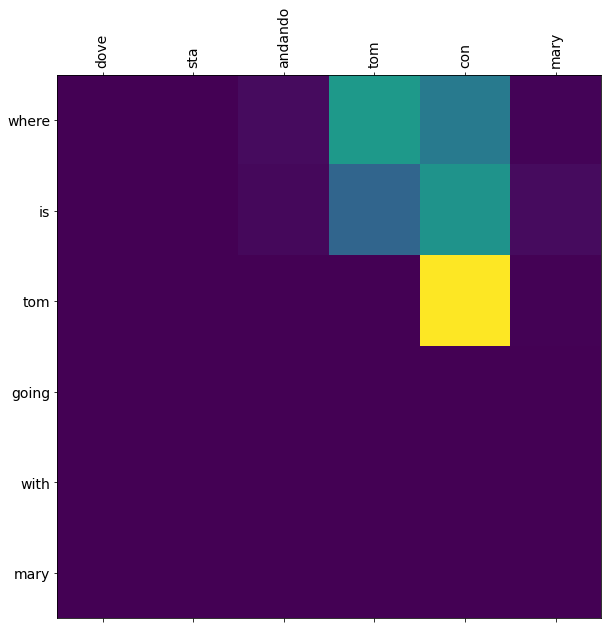

predicted output :  where is tom going with mary
actual output : where is tom going with mary <end>


In [ ]:
import warnings
warnings.filterwarnings("ignore")

sentence = train['italian'].values[57]
print('input : ', sentence)
result, attention_plot = predict_model_2(sentence)
output = get_sentence(result)
attention_plot = np.squeeze(np.squeeze(np.array(attention_plot), 1), -1)
attention_plot = attention_plot[:len(output.split(' ')), :len(sentence.split(' '))]
plot_attention(attention_plot, sentence.split(' '), output.split(' '))
print('predicted output : ',output)
print('actual output :', train['english_out'].values[57])

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from numpy.random import permutation
score =0
for i in permutation(1000):
    sentence = test['italian'].values[i]
    reference = test['english_out'].values[i][:-5]
    values, weights = predict_model_2(sentence)
    prediction = get_sentence(values)
    score+= sentence_bleu([reference.split()], prediction.split())
print('Bleu Score : {}'.format(score/1000))

Bleu Score : 0.830625967087493


# <font color='blue'>**3. Model for Concat scoring function**</font>

In [ ]:
from tensorflow.keras.callbacks import*
import os
batch_size=256
enc_unit=128
dec_unit=128
max_len = 20
embedding_dim = 64
att_units = 128

train_dataset = Dataset(train, tknizer_ita, tknizer_eng, max_len)
test_dataset  = Dataset(test, tknizer_ita, tknizer_eng, max_len)

train_dataloader = Dataloder(train_dataset, batch_size=batch_size)
test_dataloader = Dataloder(test_dataset, batch_size=batch_size)


In [ ]:
concat_score_model = encoder_decoder(vocab_size_ita+1, vocab_size_eng+1, embedding_dim, enc_unit,
                        dec_unit, max_len ,'concat', att_units, batch_size)
concat_score_model.compile(optimizer = 'Adam', loss = loss_function)
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [ModelCheckpoint('/content/drive/MyDrive/Seq_Seq_attention/Save/concat_score', save_best_only= True, verbose = 1),
             TensorBoard(log_dir = log_dir, histogram_freq=1, write_graph=True),
             EarlyStopping(patience = 5, verbose = 1, monitor = 'val_loss', mode='min'),
             ReduceLROnPlateau(patience = 1, verbose = 1, monior='val_loss', mode = 'min', factor = 0.6)]

In [ ]:
concat_score_model.fit(x = train_dataloader, 
          steps_per_epoch = train_dataloader.__len__(),
          validation_data = test_dataloader,
          validation_steps = test_dataloader.__len__(),
          epochs = 15,
          verbose = 1,
          callbacks = callbacks)

Epoch 1/15
1235/1235 [==============================] - 145s 104ms/step - loss: 1.5655 - val_loss: 1.2091

Epoch 00001: val_loss improved from inf to 1.20913, saving model to /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score/assets


Epoch 2/15
1235/1235 [==============================] - 123s 100ms/step - loss: 1.0228 - val_loss: 0.8722

Epoch 00002: val_loss improved from 1.20913 to 0.87223, saving model to /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score/assets


Epoch 3/15
1235/1235 [==============================] - 123s 100ms/step - loss: 0.7412 - val_loss: 0.6340

Epoch 00003: val_loss improved from 0.87223 to 0.63404, saving model to /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score/assets


Epoch 4/15
1235/1235 [==============================] - 124s 100ms/step - loss: 0.5232 - val_loss: 0.4635

Epoch 00004: val_loss improved from 0.63404 to 0.46350, saving model to /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score/assets


Epoch 5/15
1235/1235 [==============================] - 123s 100ms/step - loss: 0.3804 - val_loss: 0.3673

Epoch 00005: val_loss improved from 0.46350 to 0.36728, saving model to /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score/assets


Epoch 6/15
1235/1235 [==============================] - 123s 100ms/step - loss: 0.2932 - val_loss: 0.3071

Epoch 00006: val_loss improved from 0.36728 to 0.30711, saving model to /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score/assets


Epoch 7/15
1235/1235 [==============================] - 123s 100ms/step - loss: 0.2371 - val_loss: 0.2689

Epoch 00007: val_loss improved from 0.30711 to 0.26890, saving model to /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score/assets


Epoch 8/15
1235/1235 [==============================] - 123s 100ms/step - loss: 0.1983 - val_loss: 0.2452

Epoch 00008: val_loss improved from 0.26890 to 0.24518, saving model to /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score/assets


Epoch 9/15
1235/1235 [==============================] - 123s 100ms/step - loss: 0.1706 - val_loss: 0.2272

Epoch 00009: val_loss improved from 0.24518 to 0.22718, saving model to /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score/assets


Epoch 10/15
1235/1235 [==============================] - 124s 100ms/step - loss: 0.1496 - val_loss: 0.2135

Epoch 00010: val_loss improved from 0.22718 to 0.21350, saving model to /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score/assets


Epoch 11/15
1235/1235 [==============================] - 124s 100ms/step - loss: 0.1330 - val_loss: 0.2051

Epoch 00011: val_loss improved from 0.21350 to 0.20510, saving model to /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score/assets


Epoch 12/15
1235/1235 [==============================] - 124s 100ms/step - loss: 0.1196 - val_loss: 0.1957

Epoch 00012: val_loss improved from 0.20510 to 0.19571, saving model to /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score/assets


Epoch 13/15
1235/1235 [==============================] - 123s 100ms/step - loss: 0.1089 - val_loss: 0.1902

Epoch 00013: val_loss improved from 0.19571 to 0.19024, saving model to /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score/assets


Epoch 14/15
1235/1235 [==============================] - 124s 100ms/step - loss: 0.0998 - val_loss: 0.1871

Epoch 00014: val_loss improved from 0.19024 to 0.18705, saving model to /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score/assets


Epoch 15/15
1235/1235 [==============================] - 124s 100ms/step - loss: 0.0922 - val_loss: 0.1826

Epoch 00015: val_loss improved from 0.18705 to 0.18262, saving model to /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Seq_Seq_attention/Save/concat_score/assets


## <font color='blue'>**3.1 Inference Model-3**</font>

In [ ]:
def predict(input_sentence):
    '''
      A. Given input sentence, convert the sentence into integers using tokenizer used earlier
      B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
      C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
      D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
      E. Call plot_attention(#params)
      F. Return the predicted sentence
    '''
    sentencce = '<start> '+input_sentence+' <end>'
    sentencce = tknizer_ita.texts_to_sequences([sentencce])
    sentencce = pad_sequences(sentencce, maxlen=max_len, 
                              padding='post', dtype = np.int32)
    
    input_embedding = concat_score_model.layers[0].encoder_embedding(sentencce)
    initial_state =  concat_score_model.layers[0].initialize_states(1)
    ecoder_output, encoder_h, encoder_c = concat_score_model.layers[0].encoder_Lstm(input_embedding,initial_state)
    predict = np.expand_dims([tknizer_eng.word_index['<start>']], 0)
    decoder_h = encoder_h
    decoder_c = encoder_c
    prediction = []
    total_attention = []
    for words in range(max_len):
        predict, decoder_h,decoder_c,attention,_ = concat_score_model.layers[1](predict,ecoder_output,
                                                                                             decoder_h,decoder_c,training = False)
        predict = np.reshape(np.argmax(predict), (1, 1))                                                                                      
        prediction.append(predict)
        total_attention.append(attention)
    return prediction, total_attention

def get_sentence(prediction):
    output = []
    for i in prediction:
        word = tknizer_eng.index_word[i[0][0]]
        if word == '<end>':
            break
        output.append(word)
    return ' '.join(output)

input :  pensavo che potessimo parlare di tom


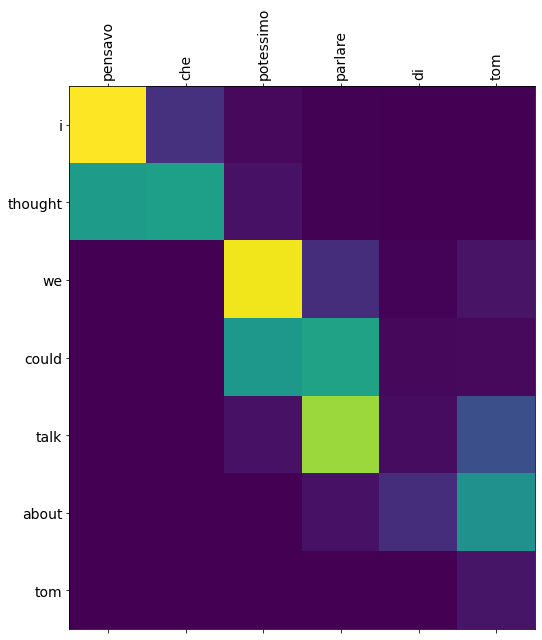

predicted output :  i thought we could talk about tom
actual output : i thought we could talk about tom <end>


In [ ]:
sentence = train['italian'].values[1248]
print('input : ', sentence)
result, attention_plot = predict(sentence)
output = get_sentence(result)
attention_plot = np.squeeze(np.squeeze(np.array(attention_plot), 1), -1)
attention_plot = attention_plot[:len(output.split(' ')), :len(sentence.split(' '))]
plot_attention(attention_plot, sentence.split(' '), output.split(' '))
print('predicted output : ',output)
print('actual output :', train['english_out'].values[1248])

In [ ]:
score =0
for i in permutation(1000):
    sentence = test['italian'].values[i]
    reference = test['english_out'].values[i]
    values, weights = predict(sentence)
    prediction = get_sentence(values)
    score+= sentence_bleu([reference.split()], prediction.split())
print('Bleu Score : {}'.format(score/1000))

Bleu Score : 0.68448575968482


# <font color='blue'>**Observation**</font>

**Bascically What we want is to compute the context vector. The context vector is a vector with the same length as the input or source sequence and is computed at every time step of the decoder. Each of its values is the score (or the probability) of the corresponding word within the source sequence; they tell the decoder what to focus on at each time step. There are three ways to calculate the scores functions which is used in three different models.**
________________________________________________________________________________
**MODEL-1:**
The hyperparameters are selected by various experiments. The best average BLEU score i got is 86%. 

What is happenning in Model-1?

I order to compute the similarity between encoder outputs and decoder hidden state. Simiply taking the dot product between the two of them which represents the similarity between them. Using this similarity score now calucation the attention weights by passing this sccore into a softmax function. In order to get the context vector we multipied the attention weight with the encoder output.

As the result in the attention weights which are plotted we can definately see that the word dependencies. Which word are has attention in order to traslate them.
________________________________________________________________________________
**MODEL-2**:
The BLEU Score obtained is 83%. 
What is happenning in Model-2?

Here the scoring function or similarity between decoder hidden state and ecoder outputs are defined as:

Passing the encoder_outputs into a dense layer, Then doing a dot product between the output from the dense layer and decoder_hidden_state.

By passing the ecoder_outputs to dense layer gives as weights which will be learned in order to get dependencies of words.
________________________________________________________________________________
**Model-3**:
The BLEU score is somewhat 68%. I personally think this can be imporved by selecting diffrent hyperparametrs. Sicne i choose the hyperparameter exprementinally.

In this Model the scoring function or the similarity is calucated as:
The decoder hidden state and encoder hidden states are added together first before being passed through a linear layer with a tanh activation function and, finally, being multiplied by a weight matrix.
In the aatention plot we can oberve that the word parlare means talk and in order to translate that particular word the attention weights are higher for talk compared to the neighouber words
________________________________________________________________________________
Since the sequnce length is fixed we cannot observe the effect of sequence length. But the all 3 attention has a drawback that it has to
attend to all words on the source side for each target word, which is computaionally expensive and can potentially hard to translate longer sequences.
To solve this problem we have Local Attention as mention in paper 
"Effective Approaches to Attention-based Neural Machine Translation"